# Daily Gun Movement Trace Analysis

This notebook focuses exclusively on analyzing gun movement traces, organizing data by day and creating overlay visualizations to track movement pattern changes over time.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from collections import defaultdict

In [2]:
# Load and organize data by day
data_dir = Path("data/holster_draw_analysis")
files = sorted(list(data_dir.glob("*.json")))

# Group sessions by date
sessions_by_date = defaultdict(list)

for file in files:
    with open(file) as f:
        content = json.load(f)
        session_date = content['session']['date'][:10]  # Extract YYYY-MM-DD
        sessions_by_date[session_date].append(content)

print(f"Found data for {len(sessions_by_date)} days:")
for date in sorted(sessions_by_date.keys()):
    total_shots = sum(len(session['session']['shots']) for session in sessions_by_date[date])
    print(f"  {date}: {len(sessions_by_date[date])} sessions, {total_shots} total shots")

Found data for 3 days:
  2025-06-25: 5 sessions, 50 total shots
  2025-06-26: 5 sessions, 50 total shots
  2025-06-27: 4 sessions, 40 total shots


## Daily Movement Trace Overlays

For each day, all movement traces are overlaid on a single plot to visualize consistency and progression.

In [3]:
def plot_daily_movement_traces(date, sessions, figsize=(10, 8)):
    """Plot all movement traces for a specific day"""
    fig, ax = plt.subplots(figsize=figsize)
    
    # Collect all traces for this day
    all_traces = []
    shot_count = 0
    
    for session in sessions:
        for shot in session['session']['shots']:
            pitch = shot.get('pitch', [])
            yaw = shot.get('yaw', [])
            if pitch and yaw:
                all_traces.append({
                    'pitch': np.array(pitch),
                    'yaw': np.array(yaw),
                    'time': shot.get('holster_total_time', 0)
                })
                shot_count += 1
    
    # Create color gradient from morning (blue) to evening (red)
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(all_traces)))
    
    # Plot each trace
    for idx, trace in enumerate(all_traces):
        ax.plot(trace['yaw'], trace['pitch'], 
                color=colors[idx], alpha=0.4, linewidth=1.5)
        # Mark start point
        ax.scatter(trace['yaw'][0], trace['pitch'][0], 
                  color=colors[idx], s=30, alpha=0.6, marker='o')
    
    # Calculate and plot average trace
    if all_traces:
        # Resample all traces to same length for averaging
        target_length = 100
        resampled_pitch = []
        resampled_yaw = []
        
        for trace in all_traces:
            # Interpolate to common length
            old_indices = np.linspace(0, len(trace['pitch'])-1, len(trace['pitch']))
            new_indices = np.linspace(0, len(trace['pitch'])-1, target_length)
            
            resampled_pitch.append(np.interp(new_indices, old_indices, trace['pitch']))
            resampled_yaw.append(np.interp(new_indices, old_indices, trace['yaw']))
        
        # Calculate average
        avg_pitch = np.mean(resampled_pitch, axis=0)
        avg_yaw = np.mean(resampled_yaw, axis=0)
        
        # Plot average trace
        ax.plot(avg_yaw, avg_pitch, 'k-', linewidth=3, alpha=0.8, label='Average')
        ax.scatter(avg_yaw[0], avg_pitch[0], color='black', s=100, marker='o', zorder=5)
        ax.scatter(avg_yaw[-1], avg_pitch[-1], color='black', s=100, marker='s', zorder=5)
    
    # Styling
    ax.set_facecolor('#f8f8f8')
    ax.grid(True, alpha=0.3, color='gray')
    ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5, alpha=0.5)
    
    ax.set_xlabel('Yaw (degrees)', fontsize=12)
    ax.set_ylabel('Pitch (degrees)', fontsize=12)
    ax.set_title(f'Movement Traces - {date}\n{shot_count} shots', fontsize=14, pad=20)
    
    if all_traces:
        ax.legend(loc='best')
    
    # Add color bar to show time progression
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1)
    cbar.set_label('Shot Order (Early → Late)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    return fig, ax, all_traces

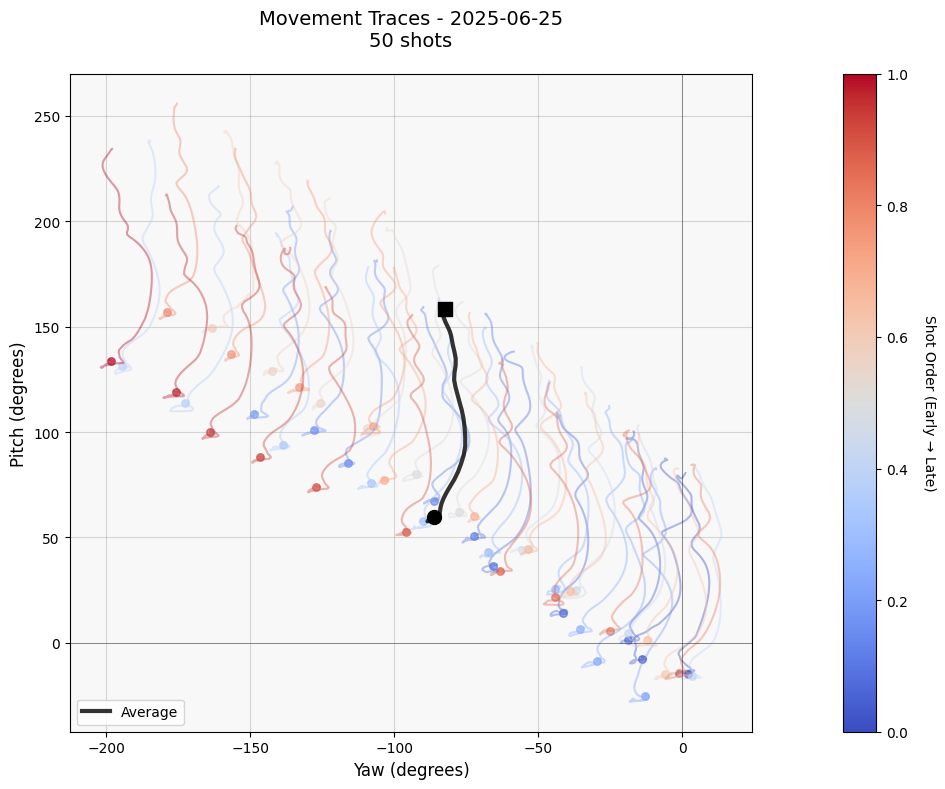

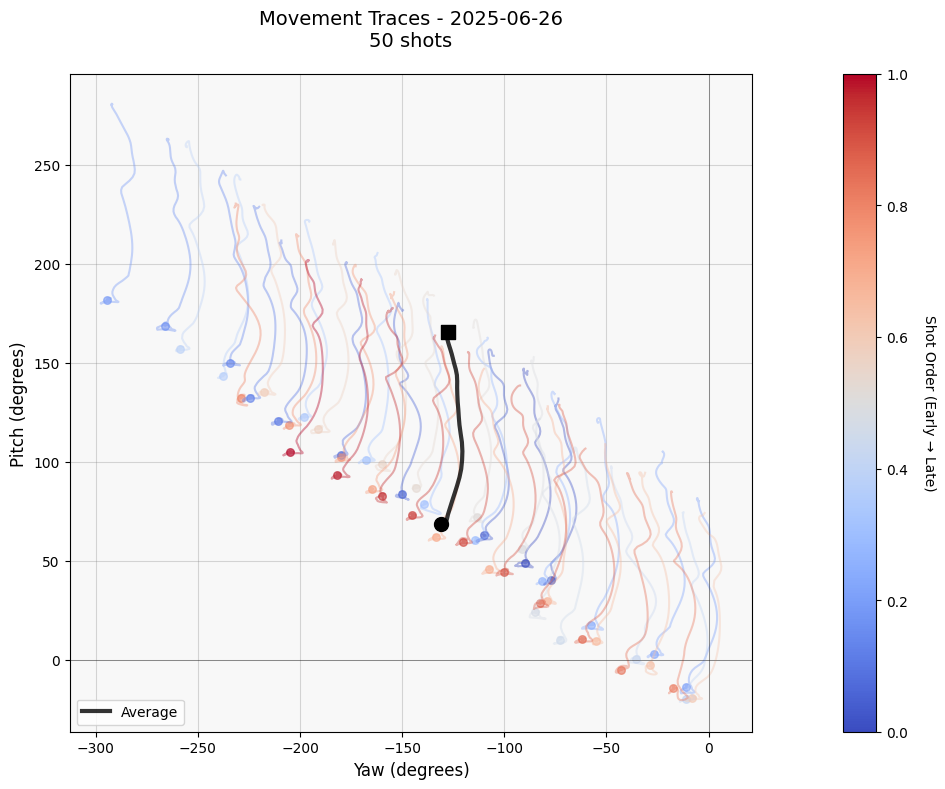

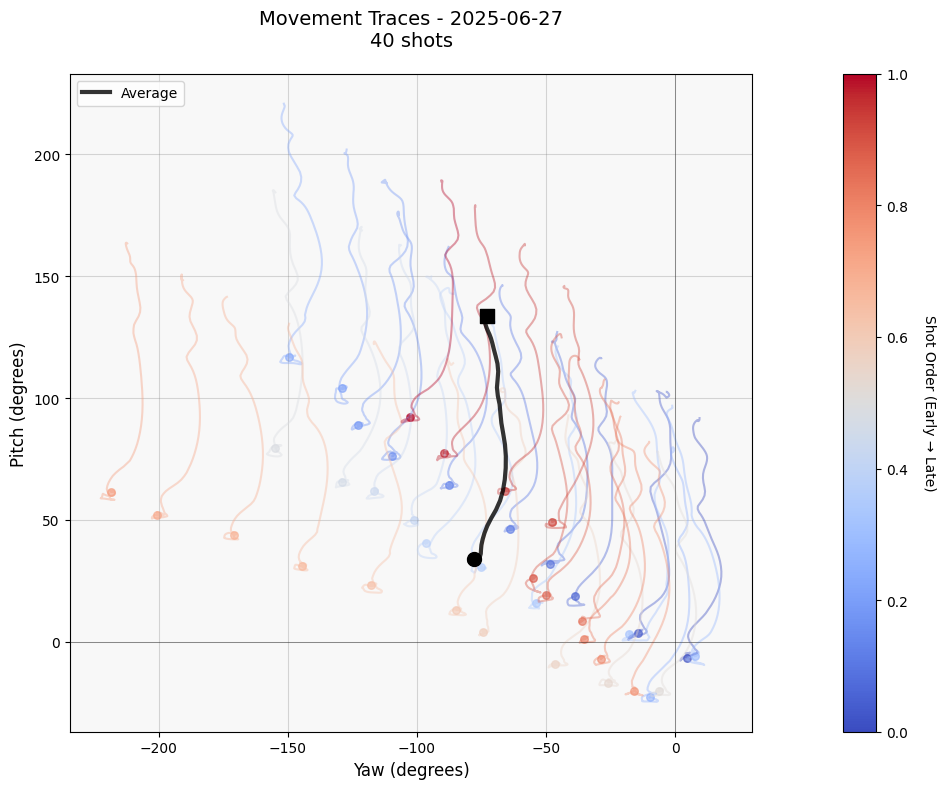

In [4]:
# Create movement trace plots for each day
daily_traces_data = {}

for date in sorted(sessions_by_date.keys()):
    fig, ax, traces = plot_daily_movement_traces(date, sessions_by_date[date])
    daily_traces_data[date] = traces
    plt.show()

## Movement Pattern Evolution

Compare average movement patterns across different days to track improvement.

In [5]:
def calculate_daily_averages(daily_traces_data):
    """Calculate average movement pattern for each day"""
    daily_averages = {}
    
    for date, traces in daily_traces_data.items():
        if not traces:
            continue
            
        # Resample all traces to same length
        target_length = 100
        resampled_pitch = []
        resampled_yaw = []
        
        for trace in traces:
            old_indices = np.linspace(0, len(trace['pitch'])-1, len(trace['pitch']))
            new_indices = np.linspace(0, len(trace['pitch'])-1, target_length)
            
            resampled_pitch.append(np.interp(new_indices, old_indices, trace['pitch']))
            resampled_yaw.append(np.interp(new_indices, old_indices, trace['yaw']))
        
        daily_averages[date] = {
            'avg_pitch': np.mean(resampled_pitch, axis=0),
            'avg_yaw': np.mean(resampled_yaw, axis=0),
            'std_pitch': np.std(resampled_pitch, axis=0),
            'std_yaw': np.std(resampled_yaw, axis=0),
            'shot_count': len(traces)
        }
    
    return daily_averages

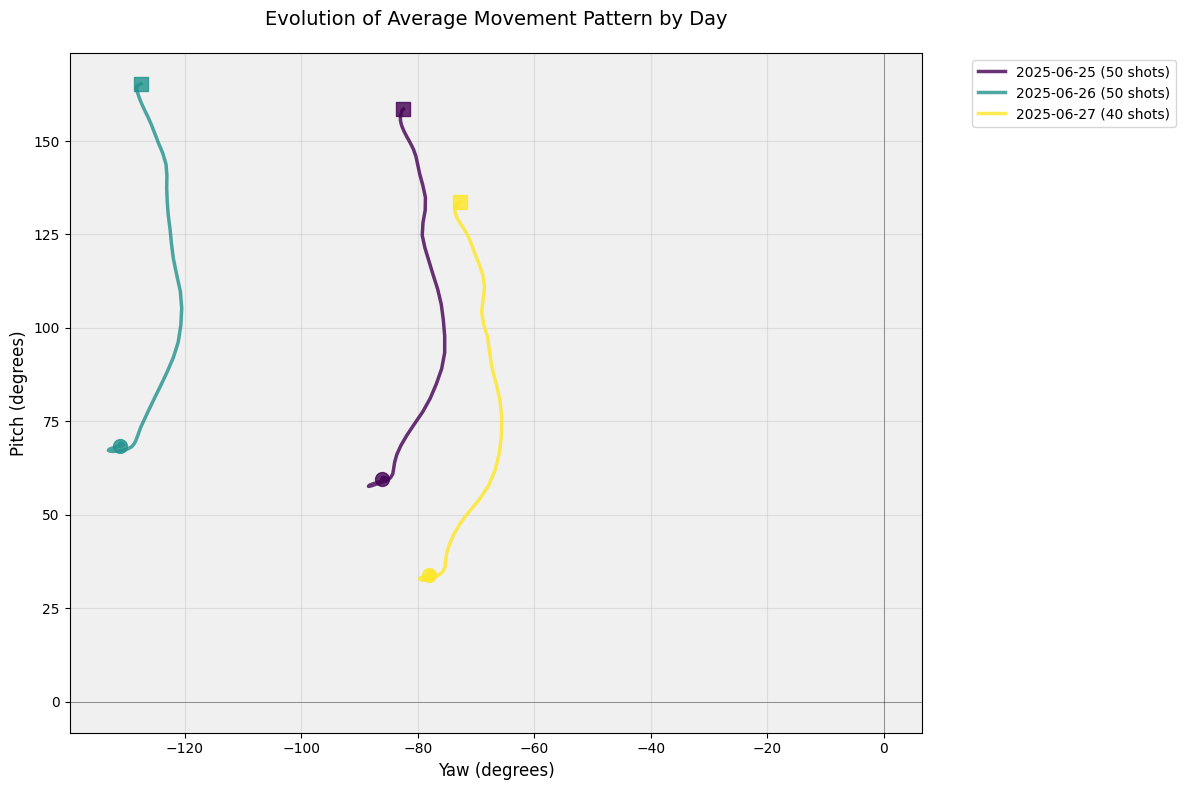

In [6]:
# Calculate daily averages
daily_averages = calculate_daily_averages(daily_traces_data)

# Plot evolution of average movement patterns
fig, ax = plt.subplots(figsize=(12, 8))

# Color gradient for different days
dates = sorted(daily_averages.keys())
colors = plt.cm.viridis(np.linspace(0, 1, len(dates)))

for idx, date in enumerate(dates):
    avg_data = daily_averages[date]
    ax.plot(avg_data['avg_yaw'], avg_data['avg_pitch'], 
            color=colors[idx], linewidth=2.5, alpha=0.8, 
            label=f"{date} ({avg_data['shot_count']} shots)")
    
    # Mark start and end
    ax.scatter(avg_data['avg_yaw'][0], avg_data['avg_pitch'][0], 
              color=colors[idx], s=100, marker='o', alpha=0.8)
    ax.scatter(avg_data['avg_yaw'][-1], avg_data['avg_pitch'][-1], 
              color=colors[idx], s=100, marker='s', alpha=0.8)

# Styling
ax.set_facecolor('#f0f0f0')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
ax.axvline(x=0, color='black', linewidth=0.5, alpha=0.5)

ax.set_xlabel('Yaw (degrees)', fontsize=12)
ax.set_ylabel('Pitch (degrees)', fontsize=12)
ax.set_title('Evolution of Average Movement Pattern by Day', fontsize=14, pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Movement Consistency Analysis

Analyze how consistent the movement patterns are within each day and how this consistency changes over time.

In [7]:
def calculate_movement_metrics(daily_traces_data):
    """Calculate various movement metrics for each day"""
    metrics_by_date = {}
    
    for date, traces in daily_traces_data.items():
        if not traces:
            continue
        
        # Calculate metrics for each trace
        total_distances = []
        pitch_ranges = []
        yaw_ranges = []
        final_positions = []
        
        for trace in traces:
            # Total movement distance
            dist = np.sum(np.sqrt(np.diff(trace['pitch'])**2 + np.diff(trace['yaw'])**2))
            total_distances.append(dist)
            
            # Range of motion
            pitch_ranges.append(trace['pitch'].max() - trace['pitch'].min())
            yaw_ranges.append(trace['yaw'].max() - trace['yaw'].min())
            
            # Final position
            final_positions.append((trace['pitch'][-1], trace['yaw'][-1]))
        
        # Calculate statistics
        final_pitch = [pos[0] for pos in final_positions]
        final_yaw = [pos[1] for pos in final_positions]
        
        metrics_by_date[date] = {
            'avg_distance': np.mean(total_distances),
            'std_distance': np.std(total_distances),
            'avg_pitch_range': np.mean(pitch_ranges),
            'avg_yaw_range': np.mean(yaw_ranges),
            'final_position_std': np.sqrt(np.std(final_pitch)**2 + np.std(final_yaw)**2),
            'shot_count': len(traces)
        }
    
    return metrics_by_date

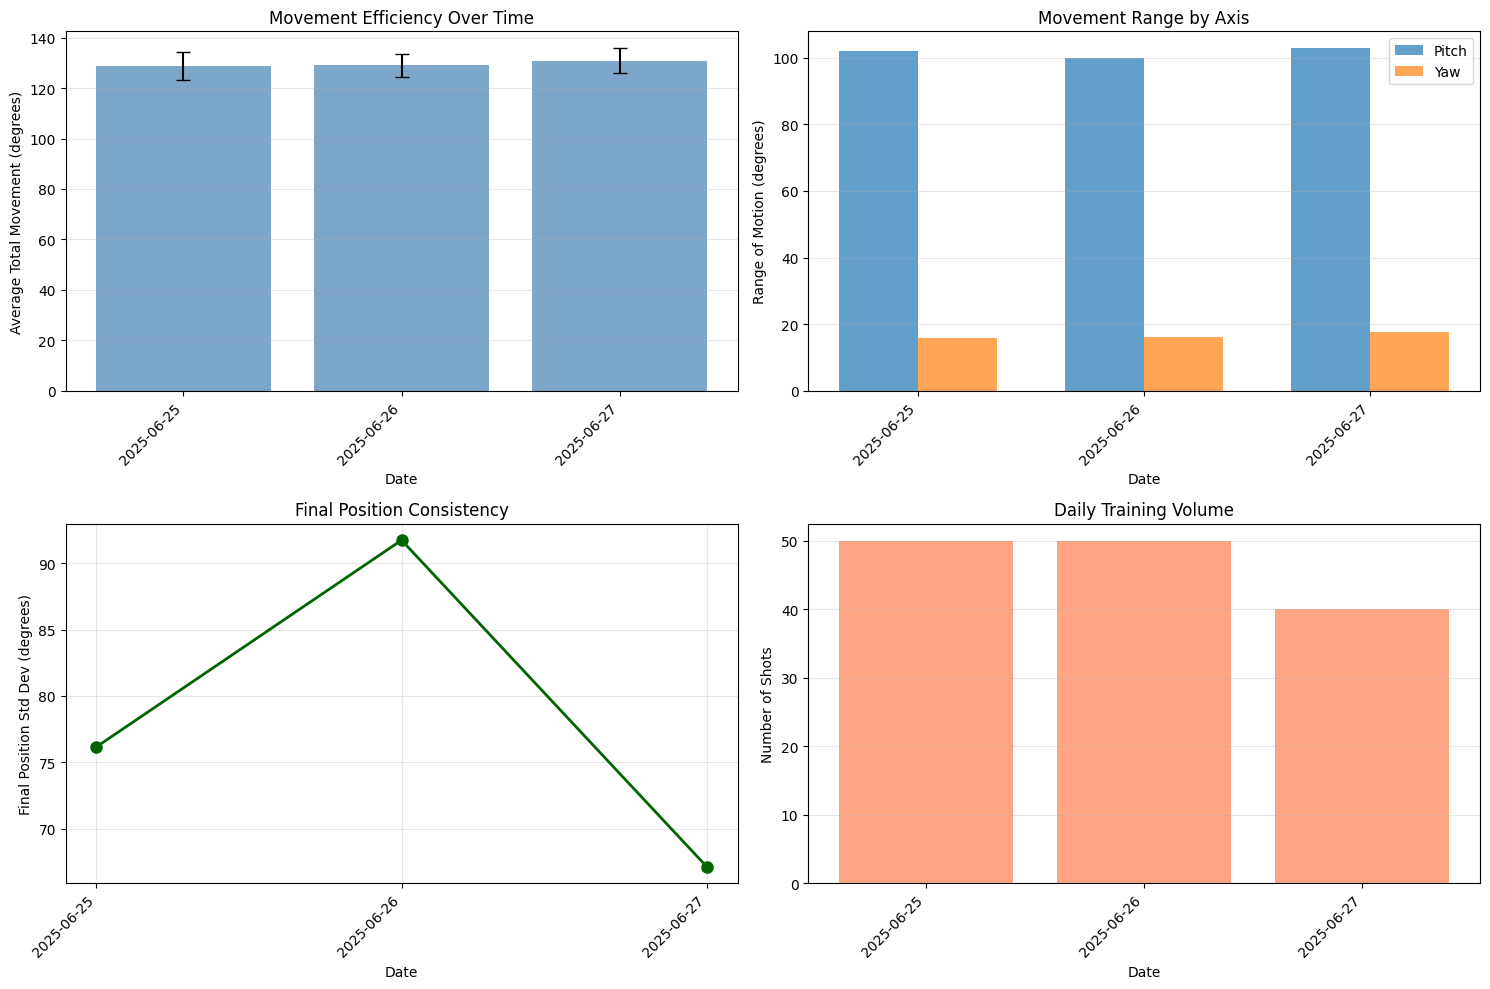

In [8]:
# Calculate movement metrics
movement_metrics = calculate_movement_metrics(daily_traces_data)

# Create metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

dates = sorted(movement_metrics.keys())
x_pos = range(len(dates))

# Total movement distance
ax = axes[0, 0]
distances = [movement_metrics[date]['avg_distance'] for date in dates]
std_distances = [movement_metrics[date]['std_distance'] for date in dates]
ax.bar(x_pos, distances, yerr=std_distances, capsize=5, alpha=0.7, color='steelblue')
ax.set_xlabel('Date')
ax.set_ylabel('Average Total Movement (degrees)')
ax.set_title('Movement Efficiency Over Time')
ax.set_xticks(x_pos)
ax.set_xticklabels(dates, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Range of motion
ax = axes[0, 1]
pitch_ranges = [movement_metrics[date]['avg_pitch_range'] for date in dates]
yaw_ranges = [movement_metrics[date]['avg_yaw_range'] for date in dates]
width = 0.35
ax.bar([x - width/2 for x in x_pos], pitch_ranges, width, label='Pitch', alpha=0.7)
ax.bar([x + width/2 for x in x_pos], yaw_ranges, width, label='Yaw', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Range of Motion (degrees)')
ax.set_title('Movement Range by Axis')
ax.set_xticks(x_pos)
ax.set_xticklabels(dates, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Final position consistency
ax = axes[1, 0]
final_std = [movement_metrics[date]['final_position_std'] for date in dates]
ax.plot(x_pos, final_std, 'o-', color='darkgreen', linewidth=2, markersize=8)
ax.set_xlabel('Date')
ax.set_ylabel('Final Position Std Dev (degrees)')
ax.set_title('Final Position Consistency')
ax.set_xticks(x_pos)
ax.set_xticklabels(dates, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Shot count per day
ax = axes[1, 1]
shot_counts = [movement_metrics[date]['shot_count'] for date in dates]
ax.bar(x_pos, shot_counts, alpha=0.7, color='coral')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Shots')
ax.set_title('Daily Training Volume')
ax.set_xticks(x_pos)
ax.set_xticklabels(dates, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Movement Heatmap Analysis

Create heatmaps showing the most common areas of gun movement for each day.

In [9]:
def create_movement_heatmap(traces, bins=50):
    """Create a 2D histogram of movement paths"""
    all_yaw = []
    all_pitch = []
    
    for trace in traces:
        all_yaw.extend(trace['yaw'])
        all_pitch.extend(trace['pitch'])
    
    if not all_yaw:
        return None, None, None
    
    # Create 2D histogram
    H, xedges, yedges = np.histogram2d(all_yaw, all_pitch, bins=bins)
    
    return H, xedges, yedges

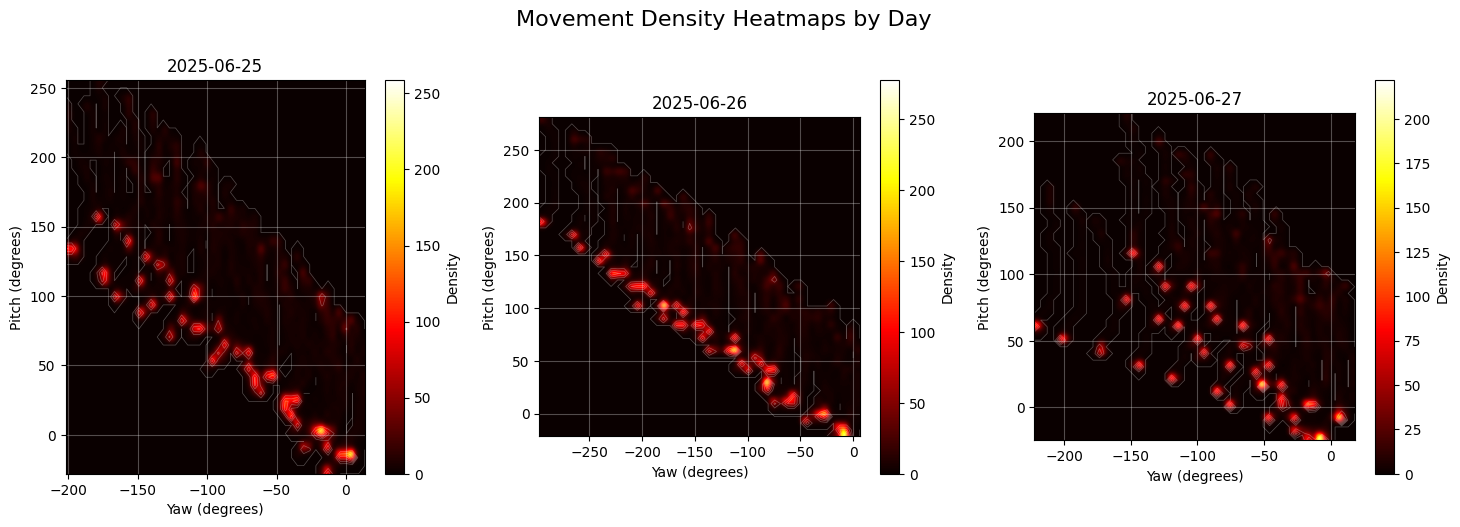

In [10]:
# Create heatmaps for each day
n_days = len(sessions_by_date)
fig, axes = plt.subplots(1, n_days, figsize=(5*n_days, 5))

if n_days == 1:
    axes = [axes]

for idx, (date, traces) in enumerate(sorted(daily_traces_data.items())):
    ax = axes[idx]
    
    H, xedges, yedges = create_movement_heatmap(traces)
    
    if H is not None:
        # Plot heatmap
        im = ax.imshow(H.T, origin='lower', 
                      extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                      cmap='hot', interpolation='gaussian')
        
        # Add contour lines
        ax.contour(H.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                  colors='white', alpha=0.3, linewidths=0.5)
        
        ax.set_xlabel('Yaw (degrees)')
        ax.set_ylabel('Pitch (degrees)')
        ax.set_title(f'{date}')
        ax.grid(True, alpha=0.3, color='white')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Density')

plt.suptitle('Movement Density Heatmaps by Day', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Summary Statistics

Overall statistics and insights from the movement trace analysis.

In [11]:
# Generate summary report
print("=== MOVEMENT TRACE ANALYSIS SUMMARY ===")
print()

# Overall statistics
total_shots = sum(len(traces) for traces in daily_traces_data.values())
print(f"Total shots analyzed: {total_shots}")
print(f"Training days: {len(daily_traces_data)}")
print(f"Average shots per day: {total_shots / len(daily_traces_data):.1f}")
print()

# Movement efficiency trends
dates = sorted(movement_metrics.keys())
if len(dates) > 1:
    first_day_dist = movement_metrics[dates[0]]['avg_distance']
    last_day_dist = movement_metrics[dates[-1]]['avg_distance']
    improvement = ((first_day_dist - last_day_dist) / first_day_dist) * 100
    
    print("Movement Efficiency:")
    print(f"  First day average distance: {first_day_dist:.1f}°")
    print(f"  Last day average distance: {last_day_dist:.1f}°")
    print(f"  Improvement: {improvement:.1f}%")
    print()

# Consistency trends
if len(dates) > 1:
    first_day_std = movement_metrics[dates[0]]['final_position_std']
    last_day_std = movement_metrics[dates[-1]]['final_position_std']
    consistency_improvement = ((first_day_std - last_day_std) / first_day_std) * 100
    
    print("Final Position Consistency:")
    print(f"  First day std dev: {first_day_std:.2f}°")
    print(f"  Last day std dev: {last_day_std:.2f}°")
    print(f"  Improvement: {consistency_improvement:.1f}%")
    print()

# Daily breakdown
print("Daily Performance:")
for date in dates:
    metrics = movement_metrics[date]
    print(f"  {date}: {metrics['shot_count']} shots, "
          f"avg distance: {metrics['avg_distance']:.1f}°, "
          f"consistency: {metrics['final_position_std']:.2f}°")

=== MOVEMENT TRACE ANALYSIS SUMMARY ===

Total shots analyzed: 140
Training days: 3
Average shots per day: 46.7

Movement Efficiency:
  First day average distance: 128.9°
  Last day average distance: 130.8°
  Improvement: -1.5%

Final Position Consistency:
  First day std dev: 76.15°
  Last day std dev: 67.13°
  Improvement: 11.9%

Daily Performance:
  2025-06-25: 50 shots, avg distance: 128.9°, consistency: 76.15°
  2025-06-26: 50 shots, avg distance: 129.0°, consistency: 91.73°
  2025-06-27: 40 shots, avg distance: 130.8°, consistency: 67.13°
